# **Business Understanding**

**Problem Statement**

> Membuat prediksi harga saham PT Telkom Indonesia (Persero) Tbk. berdasarkan dataset yang ada.

**Goal**
> Memprediksi harga saham TLKM

**Solution**
> Karena dataset terkait hanya berisi tentang data tanggal dan harga, maka solusi yang sangat tepat untuk masalah ini adalah dengan menggunakan pendekatan Time Series. 

In [71]:
!pip install opendatasets

In [72]:
# Import all required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Importing layers from keras. Use LSTM for input layer, and Dense for hidden and output layer
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential

# Import Adam Optimizers
from tensorflow.keras.optimizers import Adam

# Import for splitting test and training data set
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

from keras.callbacks import  EarlyStopping
import opendatasets as od

In [73]:
od.download("https://www.kaggle.com/fawwazzainiahmad/indonesian-government-owned-company-stock-price")

Skipping, found downloaded files in "./indonesian-government-owned-company-stock-price" (use force=True to force download)



# Data Understanding



Untuk submission ini, saya mengambil data dari [Kaggle](https://www.kaggle.com) yang bernama **[Indonesian Government Owned Company Stock Price](https://www.kaggle.com/fawwazzainiahmad/indonesian-government-owned-company-stock-price?select=TLKM.JK.csv)**. Berikut adalah daftar kolom di file CSV yang tersedia:

  * Date - Tanggal trading saham TLKM (datatype : string object)
  * Open - Harga ketika pertama kali diumumkan di tanggal tersebut (datatype : float64)
  * High - Harga tertinggi di tanggal tersebut (datatype : float64)
  * Low -  Harga terendah di tanggal tersebut (datatype : float64)
  * Close - Harga saham ketika diakhir period (datatype : float64)
  * Adj Close - Close value setelah mempertimbangkan dividen dan stock split (datatype : float64)
  * Volume - Jumlah transaksi saham di tanggal tersebut (datatype : float64)

In [74]:
df = pd.read_csv('/content/indonesian-government-owned-company-stock-price/TLKM.JK.csv', parse_dates=True, squeeze=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-09-28,835.0,835.0,825.0,825.0,117.375580,90095000.0
1,2004-09-29,825.0,825.0,810.0,825.0,117.375580,29370000.0
2,2004-09-30,825.0,830.0,825.0,830.0,118.086952,42927500.0
3,2004-10-01,830.0,845.0,825.0,840.0,119.509682,108387500.0
4,2004-10-04,845.0,880.0,845.0,870.0,123.777878,424210000.0
...,...,...,...,...,...,...,...
3975,2020-09-28,2710.0,2730.0,2660.0,2660.0,2660.000000,89256700.0
3976,2020-09-29,2690.0,2690.0,2630.0,2630.0,2630.000000,155853900.0
3977,2020-09-30,2630.0,2650.0,2540.0,2560.0,2560.000000,235611600.0
3978,2020-10-01,2600.0,2760.0,2600.0,2750.0,2750.000000,225006000.0


In [75]:
print("Total Data : {} \n".format(len(df)))
print("Date range from : {} to {}".format(df.head(1)['Date'].values, df.tail(1)['Date'].values))

Total Data : 3980 

Date range from : ['2004-09-28'] to ['2020-10-02']


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3980 entries, 0 to 3979
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3980 non-null   object 
 1   Open       3944 non-null   float64
 2   High       3944 non-null   float64
 3   Low        3944 non-null   float64
 4   Close      3944 non-null   float64
 5   Adj Close  3944 non-null   float64
 6   Volume     3944 non-null   float64
dtypes: float64(6), object(1)
memory usage: 217.8+ KB


Dari 3980 data, terdapat 3944 data yang tidak ada null valuesnya, ini artinya ada beberapa data yang null. Untuk mengatasinya, kita bisa menghapus row yang null dengan **dropna()** dari library **pandas**

In [77]:
df_new = df.dropna(how='any',axis=0) 
df_new

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-09-28,835.0,835.0,825.0,825.0,117.375580,90095000.0
1,2004-09-29,825.0,825.0,810.0,825.0,117.375580,29370000.0
2,2004-09-30,825.0,830.0,825.0,830.0,118.086952,42927500.0
3,2004-10-01,830.0,845.0,825.0,840.0,119.509682,108387500.0
4,2004-10-04,845.0,880.0,845.0,870.0,123.777878,424210000.0
...,...,...,...,...,...,...,...
3975,2020-09-28,2710.0,2730.0,2660.0,2660.0,2660.000000,89256700.0
3976,2020-09-29,2690.0,2690.0,2630.0,2630.0,2630.000000,155853900.0
3977,2020-09-30,2630.0,2650.0,2540.0,2560.0,2560.000000,235611600.0
3978,2020-10-01,2600.0,2760.0,2600.0,2750.0,2750.000000,225006000.0


In [78]:
df_new.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3944.000000,3944.000000,3944.000000,3944.000000,3944.000000,3.944000e+03
mean,2436.882860,2464.980984,2409.163286,2436.994168,1742.819242,9.844441e+07
std,1076.058496,1084.441789,1068.223754,1076.106605,1400.825963,6.096605e+07
min,820.000000,825.000000,810.000000,825.000000,117.375580,0.000000e+00
25%,1540.000000,1560.000000,1520.000000,1540.000000,443.950134,6.014665e+07
50%,2100.000000,2125.000000,2060.000000,2100.000000,1266.817993,8.548225e+07
75%,3406.250000,3456.250000,3370.000000,3422.500000,3155.009827,1.209330e+08
max,4800.000000,4840.000000,4780.000000,4800.000000,4465.643555,8.080050e+08


Sebelum menyajikan grafik dalam bentuk lineplot, karena column 'Date' masih berupa object string, maka harus diubah dahulu ke dateformat.
Ini perlu dilakukan karena kita ingin melihat perkembangan harga nya dari tahun ke tahun, bukan dari hari ke hari.

In [79]:
df_new['Date'] = pd.to_datetime(df_new['Date'] , format='%Y-%m-%d')
df_new['Date']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0      2004-09-28
1      2004-09-29
2      2004-09-30
3      2004-10-01
4      2004-10-04
          ...    
3975   2020-09-28
3976   2020-09-29
3977   2020-09-30
3978   2020-10-01
3979   2020-10-02
Name: Date, Length: 3944, dtype: datetime64[ns]

Dalam proses data understanding, saya menggunakan visualisasi data berupa grafik karena saya ingin mengetahui perkembangan harga saham TLKM dari dataset dan periode yang ada 

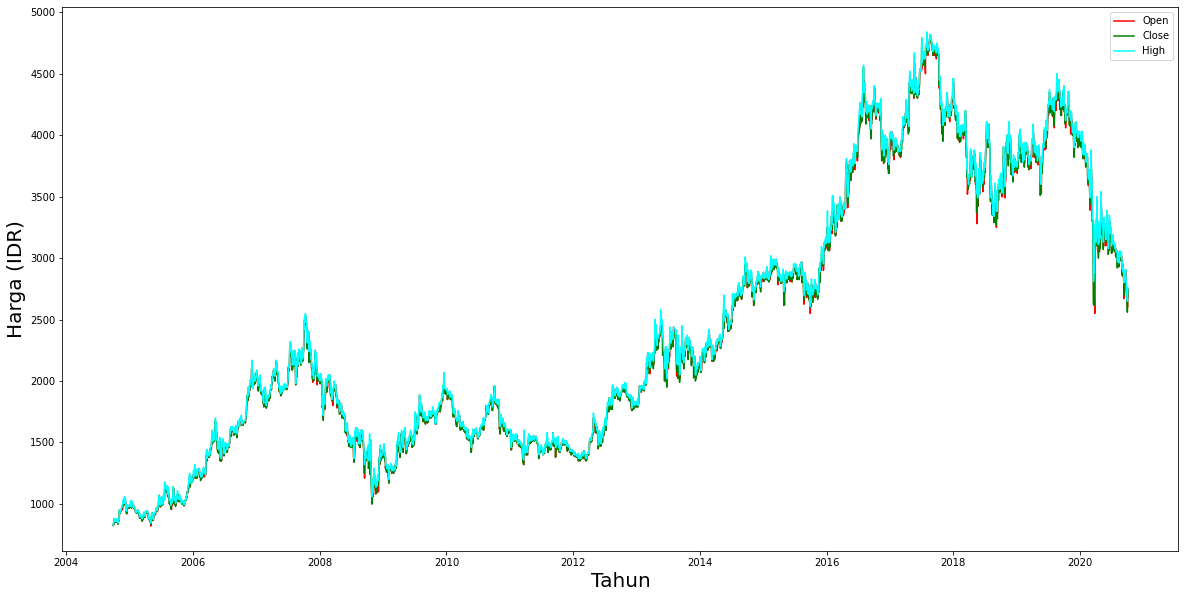

In [80]:
visual_plot =df_new[['Date','Close', 'Open', 'High']]

plt.figure(figsize=(20,10))

sns.lineplot(y=visual_plot['Open'], color="r", x=visual_plot['Date'])
sns.lineplot(y=visual_plot['Close'], color="g", x=visual_plot['Date'])
sns.lineplot(y=visual_plot['High'], color="cyan", x=visual_plot['Date'])

plt.xlabel('Tahun', fontsize=20)
plt.ylabel('Harga (IDR)', fontsize=20)
plt.legend(['Open','Close','High'], loc='upper right')



# **Data Preparation**

Memastikan bahwa dataset aman dari missing values dan tidak terdapat duplikasi 

In [81]:
df_new.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [82]:
check_duplicates = df_new[df_new.duplicated()]
print(check_duplicates)

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []


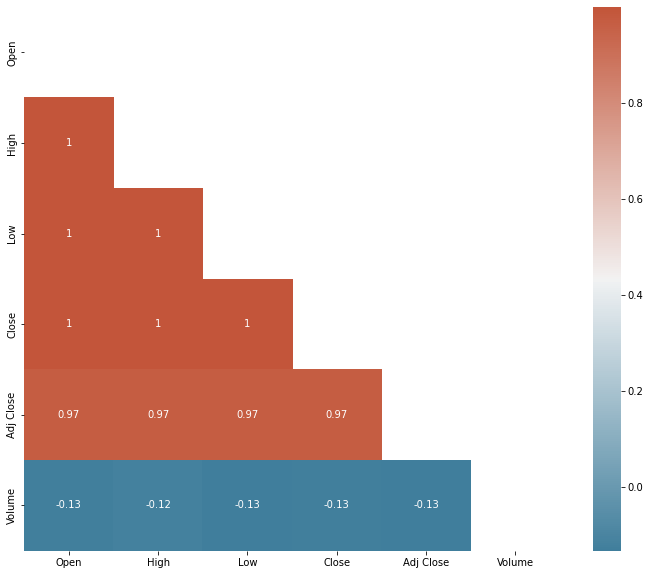

In [83]:
# Correlation between different variables
corr = df.corr()

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(12, 10))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap) 

Berdasarkan heatplot tersebut, dapat ditarik kesimpulan bahwa fitur yang saling memiliki korelasi sempurna adalah kolom High, Low, dan Close. Namun, kita 
hanya perlu menggunakan kolom 'Date' dan 'Close' untuk proses persiapan data. Kolom 'Date' sebagai indikator waktu, dan kolom 'Close' menjadi patokan harga karena merupakan harga saham TLKM pada saat hari tersebut berakhir.

In [84]:
df_new_dropped = df_new.drop(['Date','Open','High','Low', 'Volume', 'Adj Close'], axis=1)
df_new_dropped.index = df_new['Date']

In [86]:
# Splitting dataset
train_set = df_new_dropped[:int(len(df_new_dropped)*0.8) :]
test_set = df_new_dropped[int(len(df_new_dropped)*0.8):len(df_new_dropped) :]

In [87]:
train_set

,Close
Date,
2004-09-28,825.0
2004-09-29,825.0
2004-09-30,830.0
2004-10-01,840.0
2004-10-04,870.0
...,...
2017-08-28,4750.0
2017-08-29,4730.0
2017-08-30,4740.0


In [88]:
test_set

,Close
Date,
2017-09-04,4680.0
2017-09-05,4650.0
2017-09-06,4710.0
2017-09-07,4700.0
2017-09-08,4720.0
...,...
2020-09-28,2660.0
2020-09-29,2630.0
2020-09-30,2560.0


In [89]:
def dataset_preparation(dataset, window):
    dframe = []
    label = []

    for i in range(len(dataset) - window - 1):
        data = dataset[i:(i + window), 0]
        dframe.append(data)
        label.append(dataset[i+window,0])
    return np.array(dframe), np.array(label)

In [90]:
# MinMax Scaling
minmax_scaler = MinMaxScaler()
scaled_train_set = minmax_scaler.fit_transform(train_set)
scaled_test_set = minmax_scaler.fit_transform(test_set)

In [91]:
# Prepare dataset with defined window size
x_train, y_train = dataset_preparation(scaled_train_set,80)
x_test, y_test = dataset_preparation(scaled_test_set,80)


In [92]:
# Reshaping
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0], x_train.shape[1],1))

In [93]:
print("\n----MinMax Scaled Data----")
print("All data : {}".format(len(scaled_train_set)))  

print("\n----Splitted Data----")
print("Train Set shapes : {} {}".format(x_train.shape, y_train.shape))
print("Test Set shapes : {} {}".format(x_test.shape, y_test.shape))


----MinMax Scaled Data----
All data : 3155

----Splitted Data----
Train Set shapes : (3074, 80, 1) (3074,)
Test Set shapes : (708, 80, 1) (708,)


# **Arsitektur Model**

Penggunaan LSTM sebagai input layer, Dropout sebagai hidden layer, dan Dense  sebagai output layer

In [94]:
# Arsitektur Model
model = Sequential([
  LSTM(40),
  Dropout(0.5),
  Dense(32),
  Dense(1),
])

Menggunakan Adam Optimizer dengan learning rate 0.01. Menggunakan Mean Absolute Error (MAE) metrics dan Mean Squared Error (MSE) sebagai loss function

In [95]:
# Setting optimizer SGD Optimizer and learning rate
optimizer = Adam(learning_rate=0.01)

# Compile model with Huber and MAE (Mean Absolute Error) metrics
model.compile(
    metrics=["mae"],
    optimizer=optimizer,
    loss='mean_squared_error')

# **Model Training for Deep Learning**

Inisiasi Callback, EarlyStopping dari library Keras memudahkan kita untuk menghentikan proses training ketika hasil metric yang sedang dimonitor tidak ada perkembangan performa selama 5 epoch

In [96]:
callbacks = EarlyStopping(
    min_delta=0.01,
    patience=5,
    restore_best_weights=True,
)

In [97]:
# Training Model and save it to history variable.
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    validation_data=(x_test, y_test),
                    callbacks=[callbacks])

Epoch 1/20
97/97 [==============================] - 7s 42ms/step - loss: 0.0063 - mae: 0.0489 - val_loss: 0.0022 - val_mae: 0.0370
Epoch 2/20
97/97 [==============================] - 4s 41ms/step - loss: 0.0022 - mae: 0.0333 - val_loss: 0.0017 - val_mae: 0.0315
Epoch 3/20
97/97 [==============================] - 4s 38ms/step - loss: 0.0020 - mae: 0.0309 - val_loss: 0.0019 - val_mae: 0.0323
Epoch 4/20
97/97 [==============================] - 4s 37ms/step - loss: 0.0024 - mae: 0.0354 - val_loss: 0.0035 - val_mae: 0.0489
Epoch 5/20
97/97 [==============================] - 4s 38ms/step - loss: 0.0023 - mae: 0.0341 - val_loss: 0.0025 - val_mae: 0.0391
Epoch 6/20
97/97 [==============================] - 4s 38ms/step - loss: 0.0022 - mae: 0.0325 - val_loss: 0.0021 - val_mae: 0.0357


# **Model Evaluation**

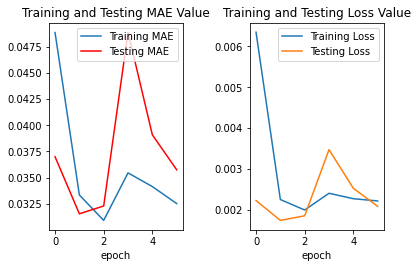

In [98]:
# Create plot for mae and val_mae
figure, axes = plt.subplots(nrows=2, ncols=2)
figure.tight_layout(pad=3.0)

plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'], 'r')
plt.title('Training and Testing MAE Value')
plt.xlabel('epoch')
plt.legend(['Training MAE', 'Testing MAE'], loc='upper right')

# Create plot for loss and val_loss
plt.subplot(1, 2, 2) # index 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Testing Loss Value')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')

plt.show()

# **Model Prediction**

In [99]:
predict_test = model.predict(x_test)
predict_test = minmax_scaler.inverse_transform(predict_test)
actual_test = minmax_scaler.inverse_transform([y_test])

Membuat dataframe baru untuk menyimpan prediction dan actual value, kemudian menambahkan kolom 'Date' dari variable df. Setelah semua kolom mempunyai data, kita dapat melihat harga asli dan prediksi harga dari data training yang telah dijalankan

In [100]:
data_predict_and_actual = {'actual_value':actual_test[0], 'prediction_value' : predict_test[:,0]}

df_predict = pd.DataFrame(data_predict_and_actual)
df_predict['Date'] = df['Date'][:len(df_predict['actual_value'])]

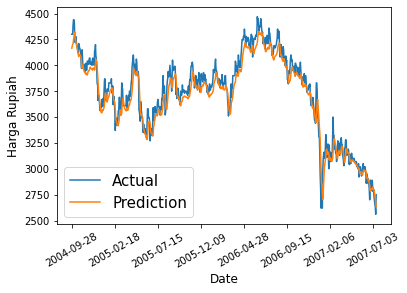

In [101]:
df_predict.plot(x="Date" )
plt.ylabel('Harga Rupiah', size=12)

plt.xlabel('Date', size=12)
plt.xticks(rotation=30)

plt.legend(["Actual", "Prediction"], fontsize=15, loc='lower left')
plt.show();